# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импортируем нужные библиотеки и функции

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Записываем данные о регионах в переменные

In [2]:
try:
    region_1 = pd.read_csv('/datasets/geo_data_0.csv')
    region_2 = pd.read_csv('/datasets/geo_data_1.csv')
    region_3 = pd.read_csv('/datasets/geo_data_2.csv')
    
except:
    region_1 = pd.read_csv('D:\\geo_data_0.csv')
    region_2 = pd.read_csv('D:\\geo_data_1.csv')
    region_3 = pd.read_csv('D:\\geo_data_2.csv')

### Изучаем данные о регионах

Данные распределены по 3-м датафреймам, поэтому для каждого датафрейма вызовем 4 функции - info, чтобы оценить общую информацию о датафрейме, наличие пропусков и т.п., hist всех числовых параметров - чтобы визуально оценить распределение, минимальные и максимальные значения параметров, часто встречающиеся значения и т.п., corr - чтобы отследить корреляцию между признаками и head чтобы оценить встречающиеся в датафрейме данные.

#### Первый регион

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Корреляция с целевым показателем product
                f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


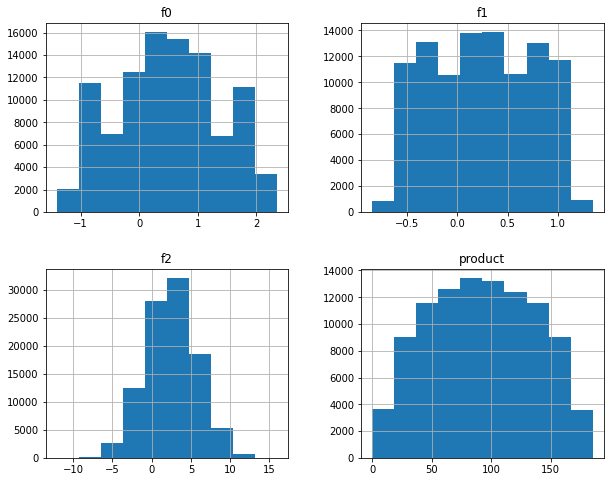

In [3]:
region_1.info()
region_1.hist(figsize=(10, 8));
print()
print('Корреляция с целевым показателем product\n', region_1.corr())
region_1.head(20)

Пустых значений нет, все столбцы имеют нужный тип, сильной корреляции не обнаружено, данные распределены близко к нормальному, кажется, с этим датафреймом всё в порядке. Сразу отмечаем, что столбец 'id' хранит в себе уникальный идентефикатор скважины, нужно будет проверить его на предмет дубликатов и потом отбросить, т.к. он бесполезен при машинном обучении.

#### Второй регион

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Корреляция с целевым показателем product
                f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


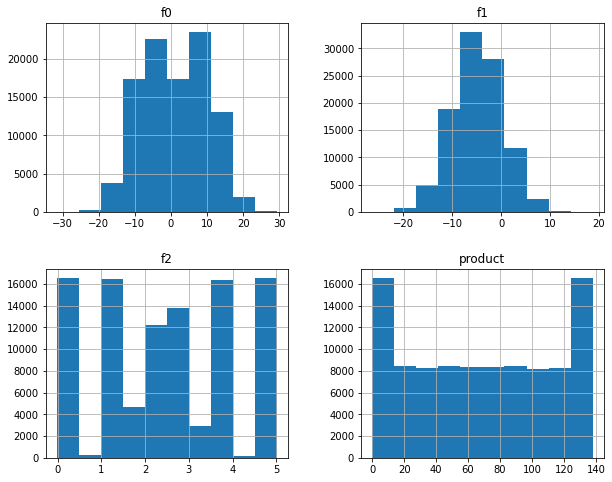

In [4]:
region_2.info()
region_2.hist(figsize=(10, 8));
print()
print('Корреляция с целевым показателем product\n', region_2.corr())
region_2.head(20)

Пропусков нет, но параметр 'f2' и целевой признак 'product' распределены ненормально, а их коэффициент корреляции почти единица. Если это не утечка целевого признака (по гистограмме можно предположить как это, так и обратное), то это хорошая корреляция, а между собой остальные параметры распределены близко к нормальному и других сильных корреляций нет. Можем отметить что средние значения параметров гораздо больше чем у первой выборки, если все выборки имеют стандартные значения параметров.

#### Третий регион

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Корреляция с целевым показателем product
                f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


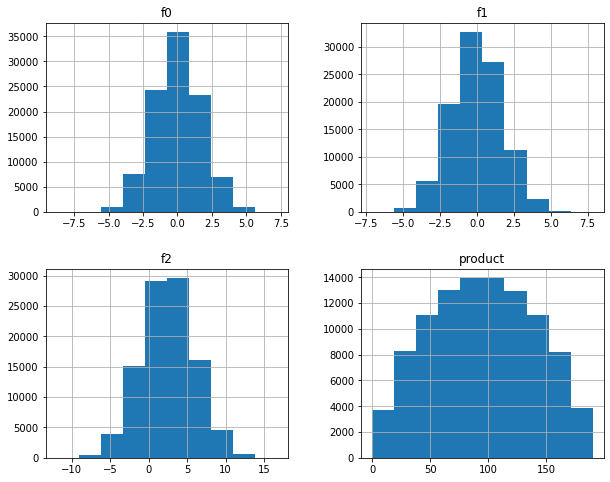

In [5]:
region_3.info()
region_3.hist(figsize=(10, 8));
print()
print('Корреляция с целевым показателем product\n', region_3.corr())
region_3.head(20)

Данные распределены близко к нормальному, сильных корреляций между параметрами нет, пропусков тоже нет. Средние значения признаков между первым и вторым датафреймом, после проверки на дубликаты наверное лучше стандартизировать параметры всех выборок. 

### Проверка на дубликаты

Для начала проверим датафреймы на явные дубликаты

In [6]:
print('Количество очевидных дубликатов в датафреймах -',
      region_1.duplicated().sum(), region_2.duplicated().sum(), region_3.duplicated().sum())

Количество очевидных дубликатов в датафреймах - 0 0 0


Явных дубликатов не обнаружено, но у нас есть столбец 'id', в котором хранятся уникальные идентификаторы всех скважин. Если мы не обнаружим дубликатов и там, то можно смело двигаться дальше

In [7]:
print('Количество дубликатов в столбце id -',
      region_1.id.duplicated().sum(), region_2.id.duplicated().sum(), region_3.id.duplicated().sum())

Количество дубликатов в столбце id - 10 4 4


Обнаружено несколько повторяющихся значений. Мы не знаем - ошибка это или нет, и если нет, и это одна скважина, то какие значения параметров для неё актуальны. Удалим оба вхождения, чтобы избежать возможных рисков вхождения ошибочных данных в выборки

In [8]:
region_1 = region_1.drop_duplicates(subset='id', keep=False).reset_index(drop=True)
region_2 = region_2.drop_duplicates(subset='id', keep=False).reset_index(drop=True)
region_3 = region_3.drop_duplicates(subset='id', keep=False).reset_index(drop=True)

region_1.info()
region_2.info()
region_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99980 entries, 0 to 99979
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99980 non-null  object 
 1   f0       99980 non-null  float64
 2   f1       99980 non-null  float64
 3   f2       99980 non-null  float64
 4   product  99980 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
--

Всё получилось, идём дальше

## Обучение и проверка модели

На предыдущем этапе мы часто выполняли одни и те же действия с трёмя наборами данных, чтобы не усложнять код мы можем определить функцию для всех действий, которые нам необходимы, и выполнить её на наших данных

In [10]:
scaler = StandardScaler()

def prediction(data):
    X = data.drop(['id', 'product'], axis=1)
    y = data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=113)
    
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = pd.Series(model.predict(X_valid), index=y_valid.index)
    rmse = mean_squared_error(y_valid, model.predict(X_valid), squared=False)
    return y_valid, predictions, rmse

In [11]:
target_1, predictions_1, rmse_1 = prediction(region_1)
print(f'Средний запас предсказанного сырья  1 региона - {predictions_1.mean():.2f} тыс. баррелей. RMSE модели - {rmse_1}')

target_2, predictions_2, rmse_2 = prediction(region_2)
print(f'Средний запас предсказанного сырья  2 региона - {predictions_2.mean():.2f} тыс. баррелей. RMSE модели - {rmse_2}')

target_3, predictions_3, rmse_3 = prediction(region_3)
print(f'Средний запас предсказанного сырья  3 региона - {predictions_3.mean():.2f} тыс. баррелей. RMSE модели - {rmse_3}')

Средний запас предсказанного сырья  1 региона - 92.72 тыс. баррелей. RMSE модели - 37.798618376108635
Средний запас предсказанного сырья  2 региона - 69.37 тыс. баррелей. RMSE модели - 0.8866257842148186
Средний запас предсказанного сырья  3 региона - 94.98 тыс. баррелей. RMSE модели - 39.90406582762287


У 1 и 3 региона больше средний предсказанный запас, но так же RMSE гораздо больше, чем у более скромного на средние баррели второго региона. Если мы вспомним гистограммы из предыдущего этапа, то в 1 и 3 наборе данных распределение столбца product было близко к нормальному, а у второго набора оно было равномерным с двумя пиковыми значениями - возле минимума (нуля) и возле максимума, так что возможно и 200 и 500 скважин с хорошим объемом продукта там может набраться.

## Подготовка к расчёту прибыли

### Сохраняем ключевые значения

Чтобы подготовиться к рассчёту прибыли, сохраним все ключевые значения в отдельные глобальные переменные, которые и будем использовать в рассчётах(на случай если они изменятся в будущем, такой параметр как доход с одного барреля весьма вероятно будет ходить вверх-вниз). Наши переменные:
- количество точек, которые исследуют при разведке региона (research_spots, значение по умолчанию - 500)
- количество точек, которые отбирают для разработки при помощи машинного обучения (top_spots, значение по умолчанию - 200)
- бюджет на разработку скважин в регионе (region_budget, значение по условию задачи -  10000000000 (10 млрд.))
- доход с одного барреля (barrel_profit, значение по условию задачи - 450)
- доход с одной единицы целевого признака product, с тысячи баррелей (pассчитывается по формуле доход с одного барреля * 1000)
- максимально допустимая вероятность убытков, превышение которой исключает регион из возможных вариантов (max_loss_prob, значение по умолчанию - 0.025)

In [12]:
RESEARCH_SPOTS = 500
TOP_SPOTS = 200
REGION_BUDGET = 10_000_000_000
BARREL_PROFIT = 450
PRODUCT_PROFIT = BARREL_PROFIT * 1000
MAX_LOSS_PROB = 0.025

### Считаем безубыток по новой скважине

Теперь посчитаем достаточный объём сырья (единицы product) для безубыточной разработки новой скважины по формуле бюджет региона / количество скважин в регионе / доход с одной единицы сырья

In [13]:
REGION_BUDGET / TOP_SPOTS / PRODUCT_PROFIT

111.11111111111111

111 и 1 в периоде. Это больше, чем 93 и 95 единиц в 1 и 3 регионе соответственно, и намного больше, чем во 2 регионе с его 70 баррелями в среднем. Если в 1 и 3 регионе нам необходимо улучшить средний результат примерно на 25%, то во 2 нам требуется увеличение уже более чем на 50% от среднего значения. Разработка второго региона кажется уже менее вероятной, но пока мы не увидим цифры, сдаваться рано.

Теперь определим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

### Определяем функцию для расчёта прибыли

In [14]:
def profit(target, predictions):
    target.index = range(len(target))
    predictions.index = target.index
    spots = predictions.sort_values(ascending=False)[:TOP_SPOTS]
    income = target[spots.index].sum() * PRODUCT_PROFIT
    profit = income - REGION_BUDGET
    return profit

Посчитаем прибыль с лучших, по предсказаниям наших моделей, скважин каждого региона

In [15]:
print(f'Прибыль с лучших {TOP_SPOTS} скважин в 1 регионе {profit(target_1, predictions_1):.0f} рублей')
print(f'Прибыль с лучших {TOP_SPOTS} скважин во 2 регионе {profit(target_2, predictions_2):.0f} рублей')
print(f'Прибыль с лучших {TOP_SPOTS} скважин в 3 регионе {profit(target_3, predictions_3):.0f} рублей')

Прибыль с лучших 200 скважин в 1 регионе 3168502834 рублей
Прибыль с лучших 200 скважин во 2 регионе 2415086697 рублей
Прибыль с лучших 200 скважин в 3 регионе 2778499595 рублей


Прибыль реально получить во всех трёх регионах, это уже радует! Теперь посчитаем, каком регионе мы в среднем получим самую большую прибыль, и самое главное, в каком у нас минимальный шанс получить убыток

## Расчёт прибыли и рисков 

### Определяем функцию с bootstrap

Определяем функцию bootstrap_profit - с её помощью мы создаём 1000 случайных выборок из нашей основной выборки, на которые мы применяем нашу функцию profit

Такой объём данных позволит нам получить представление о прибыльности не лучших 200 скважин в регионе, а лучших 200 из 500, которые случайно исследуют при разведке региона

In [16]:
state = np.random.RandomState(113)

def bootstrap_profit(target, predictions):
    values = []
    for i in range(1000):
        subsample_target = target.sample(n=RESEARCH_SPOTS, replace=True, random_state=state)
        subsample_predictions = predictions[subsample_target.index]
        values.append(profit(subsample_target, subsample_predictions))
    values = pd.Series(values)
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    loss = (values < 0).sum() / 1000
    return mean, lower, upper, loss

### Рассчёт прибыли и рисков

In [17]:
mean_1, lower_1, upper_1, loss_1 = bootstrap_profit(target_1, predictions_1)

print('Регион 1:')
print(f'Средняя прибыль - {mean_1:.0f} рублей')
print(f'95%-тный доверительный интервал - от {lower_1:.0f} до {upper_1:.0f} рублей')
print(f'Вероятность убытка - {loss_1:.2%}')
if loss_1 > MAX_LOSS_PROB:
    print('Убытки превышают предельное значение, регион не рассматривается к разработке ')

Регион 1:
Средняя прибыль - 413463621 рублей
95%-тный доверительный интервал - от -80529388 до 913761553 рублей
Вероятность убытка - 5.30%
Убытки превышают предельное значение, регион не рассматривается к разработке 


In [18]:
mean_2, lower_2, upper_2, loss_2 = bootstrap_profit(target_2, predictions_2)

print('Регион 2:')
print(f'Средняя прибыль - {mean_2:.0f} рублей')
print(f'95%-тный доверительный интервал - от {lower_2:.0f} до {upper_2:.0f} рублей')
print(f'Вероятность убытка - {loss_2:.2%}')
if loss_2 > MAX_LOSS_PROB:
    print('Убытки превышают предельное значение, регион не рассматривается к разработке ')

Регион 2:
Средняя прибыль - 503837343 рублей
95%-тный доверительный интервал - от 122365082 до 920157247 рублей
Вероятность убытка - 0.30%


In [19]:
mean_3, lower_3, upper_3, loss_3 = bootstrap_profit(target_3, predictions_3)

print('Регион 3:')
print(f'Средняя прибыль - {mean_3:.0f} рублей')
print(f'95%-тный доверительный интервал - от {lower_3:.0f} до {upper_3:.0f} рублей')
print(f'Вероятность убытка - {loss_3:.2%}')
if loss_3 > MAX_LOSS_PROB:
    print('Вероятность убытка превышает предельное значение, регион не рассматривается к разработке ')

Регион 3:
Средняя прибыль - 326148304 рублей
95%-тный доверительный интервал - от -180151111 до 824717538 рублей
Вероятность убытка - 10.50%
Вероятность убытка превышает предельное значение, регион не рассматривается к разработке 


### Предлагаемый регион для разработки

Для разработки месторождения предлагаю второй регион, в остальных регионах слишком велик риск убытка

Второй регион, не смотря на ненормальное распределение, кажется, благодаря сильной корреляции параметра 'f2' с целевым признаком и вследствие этого хорошей предсказуемостью, является самым перспективным для бурения новых скважин. Наша функция предсказала ему самую большую среднюю прибыль, самый высокий доверительный интервал и самую маленькую вероятность убытка.